This notebook reads NX3 data sample from Rito: https://drive.google.com/drive/u/1/folders/1aeFfvOS7OzU3j44-rs_UHGnX9IsUwX-7.

June 20, 2025

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def eConvertLVBinS(fname):
    with open(fname, 'rb') as fid:
        # Read first two doubles (big-endian): Ncoeffs and Nchs
        header = np.fromfile(fid, dtype='>d', count=2)
        Ncoeffs = int(header[0])
        Nchs = int(header[1])
        
        # Read coefficient matrix [Ncoeffs, Nchs] (big-endian)
        coeffs = np.fromfile(fid, dtype='>d', count=Ncoeffs*Nchs)
        coeffs = coeffs.reshape((Ncoeffs, Nchs), order='F')  # Column-major order
        
        # Extract parameters
        dt_vals = 1.0 / coeffs[0, :]      # Sampling intervals (1/frequencies)
        offsets = coeffs[1, :]             # DC offsets
        gains = coeffs[2:, :]              # Polynomial coefficients
        
        # Read int16 time-series data [Nchs, Nsamples] (big-endian)
        data_int16 = np.fromfile(fid, dtype='>i2')
        Nsamples = data_int16.size // Nchs
        data_int16 = data_int16.reshape((Nchs, Nsamples), order='F')
        
        # Initialize output with offsets
        b = np.tile(offsets[:, np.newaxis], (1, Nsamples))
        
        # Apply polynomial calibration: b += Σ(gains_k * data^k)
        for k in range(gains.shape[0]):
            exponent = k + 1
            term = gains[k, :][:, np.newaxis] * (data_int16 ** exponent)
            b += term
        
        # Create time vector using first channel's dt
        time_vector = np.arange(Nsamples) * dt_vals[0]
        
        # Combine time vector with channel data (transposed to [Nsamples, Nchs])
        return np.column_stack((time_vector, b.T))

# Example usage
filenum = "timeS66.bin"
a = eConvertLVBinS(filenum)

tt = a[:, 0]    # Time vector (1st column)
I = a[:, 1]     # I-channel data (2nd column)
Q = a[:, 2]     # Q-channel data (3rd column)

fs = 1 / np.mean(np.diff(tt))  # Calculate sampling frequency
dt = 1 / fs
Z_ts_raw = I + 1j * Q          # Create complex signal

np.save(filenum[:-4]+".npy", Z_ts_raw)

Text(0.5, 1.0, 'timeS66')

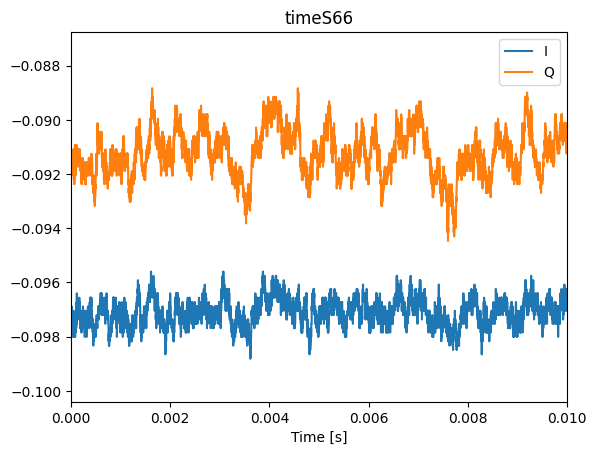

In [11]:
plt.plot(tt, I, label="I")
plt.plot(tt, Q, label="Q")
plt.xlabel("Time [s]")
plt.xlim(0, 0.01)
plt.legend()
plt.title(filenum[:-4])

Text(0.5, 1.0, 'timeS66')

/opt/anaconda3/envs/straxion/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/envs/straxion/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


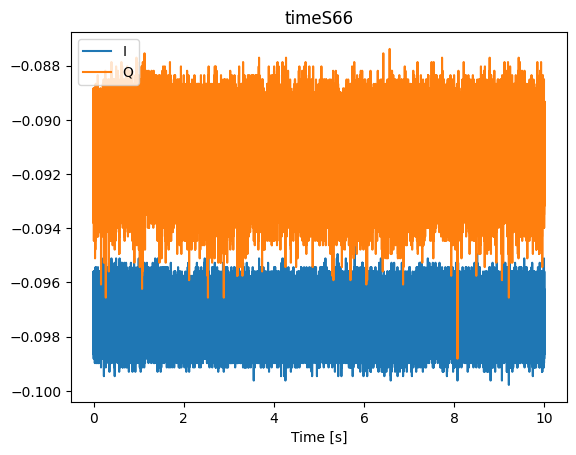

In [12]:
plt.plot(tt, I, label="I")
plt.plot(tt, Q, label="Q")
plt.xlabel("Time [s]")
plt.legend()
plt.title(filenum[:-4])

Now we try to play with the other batch of data samples from [Chris Albert](https://caltechobscosgroup.slack.com/archives/C07SZDKRNF9/p1752016440924679?thread_ts=1752010145.654029&cid=C07SZDKRNF9).

*"The .bin is the raw timestream file that auto_pulse_tagger reads in line 15. The .txt contains the frequency vs I,Q for the resonator, and the .bin data is the I,Q data taken at the frequency where the resonator most responsive. auto_pulse_tagger uses the .txt in line 19, where it converts the photon IQ pulses into changes in angle around the IQ loop of the resonator"*

In [13]:
filenum = "timeS429.bin"
a = eConvertLVBinS(filenum)

tt = a[:, 0]    # Time vector (1st column)
I = a[:, 1]     # I-channel data (2nd column)
Q = a[:, 2]     # Q-channel data (3rd column)

fs = 1 / np.mean(np.diff(tt))  # Calculate sampling frequency
dt = 1 / fs
Z_ts_raw = I + 1j * Q          # Create complex signal

np.save(filenum[:-4]+".npy", Z_ts_raw)

In [18]:
np.shape(a)

(5000000, 3)

Text(0.5, 1.0, 'timeS429')

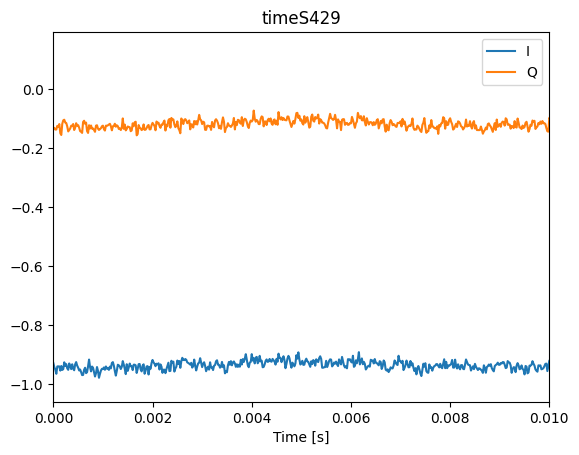

In [14]:
plt.plot(tt, I, label="I")
plt.plot(tt, Q, label="Q")
plt.xlabel("Time [s]")
plt.xlim(0, 0.01)
plt.legend()
plt.title(filenum[:-4])

Text(0.5, 1.0, 'timeS429')

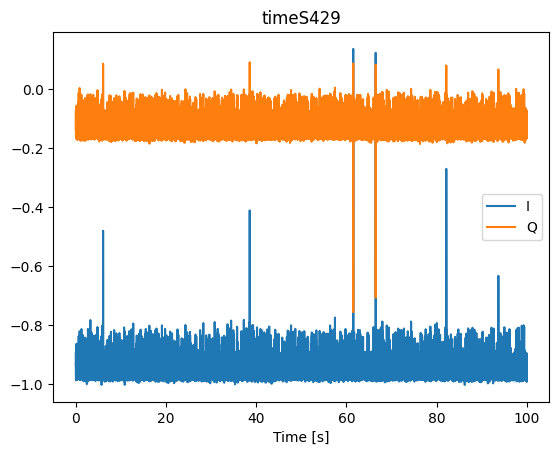

In [15]:
plt.plot(tt, I, label="I")
plt.plot(tt, Q, label="Q")
plt.xlabel("Time [s]")
plt.legend()
plt.title(filenum[:-4])

OK we can confirm that the loaded result of Chris' bin files seems somewhat sensitive by the same loading code. Now, what we want will be comparing it to the result by Chris' txt file.

In [16]:
# Read the file as a numpy array
txt_data = np.loadtxt('iq428.txt')

# Now data is a 2D numpy array: rows = lines, columns = values per line
print(txt_data.shape)  # (number_of_rows, 3)
print(txt_data[:5])    # Print first 5 rows

(1000, 3)
[[ 6.02395000e+08 -5.67602429e-01 -1.24906431e+00]
 [ 6.02395250e+08 -5.67887921e-01 -1.24921716e+00]
 [ 6.02395500e+08 -5.68283384e-01 -1.24930414e+00]
 [ 6.02395750e+08 -5.68485386e-01 -1.24908331e+00]
 [ 6.02396000e+08 -5.68996525e-01 -1.24880527e+00]]


Text(0.5, 1.0, 'iq428')

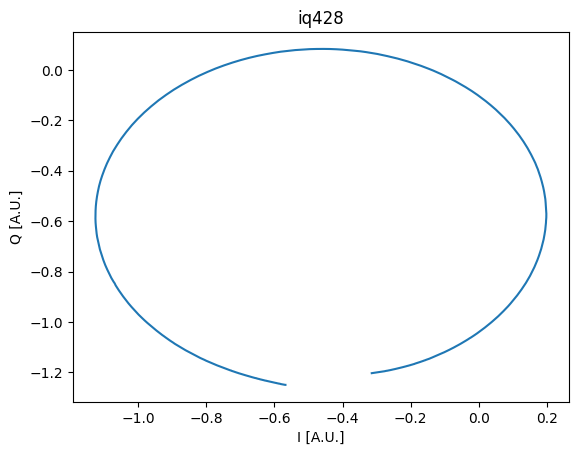

In [26]:
plt.plot(txt_data[:,1], txt_data[:,2])
plt.xlabel("I [A.U.]")
plt.ylabel("Q [A.U.]")
plt.title("iq428")

Text(0.5, 1.0, 'iq428')

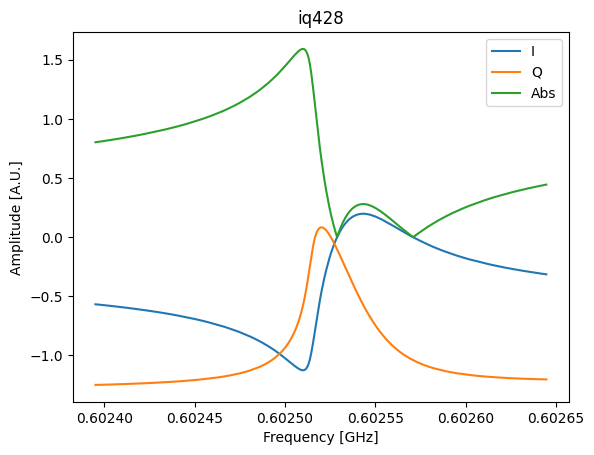

In [27]:
plt.plot(txt_data[:,0]/1e9, txt_data[:,1], label="I")
plt.plot(txt_data[:,0]/1e9, txt_data[:,2], label="Q")
plt.plot(txt_data[:,0]/1e9, np.sqrt(txt_data[:,1]**2 + txt_data[:,1]**2), label="Abs")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Amplitude [A.U.]")
plt.legend()
plt.title("iq428")